In [1]:
# Mount Google Drive is faster than uploading data. Move repository into Google Drive and update path at end of this section
from google.colab import drive
drive.mount('/content/gdrive') # Don't Update
# Import packages
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(541)
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras, random
random.set_seed(541)
import numpy as np
# Import helper functions from pre_processing.py:
import sys
import os
sys.path.append('/content/gdrive/My Drive/RNN_GRF_Prediction/')  # or '/content/gdrive/My Drive/PATH/TO/REPOSITORY/'
directory = '/content/gdrive/My Drive/RNN_GRF_Prediction/data/'
from pre_processing import *

directory = '/content/gdrive/My Drive/RNN_GRF_Prediction/data/'  # or '/content/gdrive/My Drive/PATH/TO/REPOSITORY/'

Mounted at /content/gdrive


In [6]:
## Load data ----
fs = 500  # Sampling Frequency

# Accelerometer Data
X = pd.read_csv(os.path.join(directory, 'Accelerometer.csv'), header=None).values
# Subject and Condition Data
Sub_Info = pd.read_csv(os.path.join(directory, 'Sub_Info.csv'))
# Normal GRF data
y = pd.read_csv(os.path.join(directory, 'GRF.csv'), header=None).values

## Train/Test Split ----
train_X = X[(Sub_Info['Slope'] != -5) | (Sub_Info['Slope'] != 5),:]
train_y = y[(Sub_Info['Slope'] != -5) | (Sub_Info['Slope'] != 5),:]
train_Sub_Info = Sub_Info.loc[(Sub_Info['Slope'] != -5) | (Sub_Info['Slope'] != 5),:]
train_Sub_Info.reset_index(drop=True, inplace=True)

test_X = X[(Sub_Info['Slope'] == -5) | (Sub_Info['Slope'] == 5),:]
test_y = y[(Sub_Info['Slope'] == -5) | (Sub_Info['Slope'] == 5),:]
test_Sub_Info = Sub_Info.loc[(Sub_Info['Slope'] == -5) | (Sub_Info['Slope'] == 5),:]
test_Sub_Info.reset_index(drop=True, inplace=True)

## Scale Features ----
l = 2480  # Accelerometer data is concatenated
train_X_V = train_X[:,0:l]
train_X_AP = train_X[:,l:l*2]
test_X_V = test_X[:,0:l]
test_X_AP = test_X[:,l:l*2]

# Sub_Info
train_Sub_Feats = train_Sub_Info[['Height', 'Mass', 'Speed', 'Slope']]
test_Sub_Feats = test_Sub_Info[['Height', 'Mass', 'Speed', 'Slope']]
scaler_sub = MinMaxScaler()
train_Sub_Feats = pd.DataFrame(scaler_sub.fit_transform(train_Sub_Feats))
test_Sub_Feats = pd.DataFrame(scaler_sub.transform(test_Sub_Feats))
train_Sub_Feats.columns = ['Height', 'Mass', 'Speed', 'Slope']
test_Sub_Feats.columns = ['Height', 'Mass', 'Speed', 'Slope']

#Don't include foot strike percentages in min/max scaler because they're 
#already scaled to each other. min/max scaler is per feature (column).
train_Sub_Feats[['RFS', 'MFS', 'FFS']] = train_Sub_Info[['RFS', 'MFS', 'FFS']].copy()/100
test_Sub_Feats[['RFS', 'MFS', 'FFS']] = test_Sub_Info[['RFS', 'MFS', 'FFS']].copy()/100

# Copy over Subject ID
train_Sub_Feats['Sub'] = train_Sub_Info['Sub']
test_Sub_Feats['Sub'] = train_Sub_Info['Sub'][0]
sub_num = 2

## Split accelerometer data into overlapping windows for RNN ----
# N-frame windows centered on prediction frame. Pad w/ nearest value ----
window_size = 6  # 6 frames @ 500 Hz == 12 ms

train_X_V = window_data_centered(train_X_V, window_size, verbose=False)
train_X_AP = window_data_centered(train_X_AP, window_size, verbose=False)
train_y = np.reshape(train_y, (train_y.shape[0],train_y.shape[1],1))

test_X_V = window_data_centered(test_X_V, window_size, verbose=False)
test_X_AP = window_data_centered(test_X_AP, window_size, verbose=False)
test_y = np.reshape(test_y, (test_y.shape[0],test_y.shape[1],1))

In [7]:
## Generate Features ----
# Calculates mean, sd, range in each window of accelerometer data. generate_features() can also reshape sub_info to match dimensions.
train_feats_V = generate_features(train_X_V, fs, train_Sub_Feats, -sub_num, include_sub_info_feats=False)  # Just signal feats
train_feats_AP = generate_features(train_X_AP, fs, train_Sub_Feats, -sub_num, include_sub_info_feats=True)  # Signal and Sub_Info feats
sub_info_feats = train_feats_AP[-7:-1].copy()
test_feats_V = generate_features(test_X_V, fs, test_Sub_Feats, -sub_num, include_sub_info_feats=False)  # Just signal feats
test_feats_AP = generate_features(test_X_AP, fs, test_Sub_Feats, -sub_num, include_sub_info_feats=True)  # Signal and Sub_Info feats

train_sub_info_feats = train_feats_AP[:,:,-7:].copy()
train_feats_AP = train_feats_AP[:,:,0:3].copy()

test_sub_info_feats = test_feats_AP[:,:,-7:].copy()
test_feats_AP = test_feats_AP[:,:,0:3].copy()

# #remove footstrike features if that's not your thing
# train_sub_info_feats = train_sub_info_feats[:,:,0:4]
# test_sub_info_feats = test_sub_info_feats[:,:,0:4]

def max_scale_3d(feats, train_max):
  feats_scaled = feats / train_max
  return feats_scaled

train_feats_V_scaled = max_scale_3d(train_feats_V, np.max(train_feats_V, axis=(0,1)))
train_feats_AP_scaled = max_scale_3d(train_feats_AP, np.max(train_feats_AP, axis=(0,1)))

test_feats_V_scaled = max_scale_3d(test_feats_V, np.max(train_feats_V, axis=(0,1)))
test_feats_AP_scaled = max_scale_3d(test_feats_AP, np.max(train_feats_AP, axis=(0,1)))

train_feats = np.concatenate((train_feats_V_scaled, train_feats_AP_scaled, train_sub_info_feats), axis = 2)
test_feats = np.concatenate((test_feats_V_scaled, test_feats_AP_scaled, test_sub_info_feats), axis = 2)

print('TRAINING DATA: \nNumber of trials: %d \nNumber of overlapping windows: %d \nNumber of features per window: %d' % train_feats.shape)
print('\nTESTING DATA: \nNumber of trials: %d \nNumber of overlapping windows: %d \nNumber of features per window: %d' % test_feats.shape)

TRAINING DATA: 
Number of trials: 31 
Number of overlapping windows: 2480 
Number of features per window: 13

TESTING DATA: 
Number of trials: 13 
Number of overlapping windows: 2480 
Number of features per window: 13


In [8]:
## Construct Model ----
def build_model(lr=0.001, loss='mean_squared_error'):

  #accelerometer data lstm model
  accel_inputs = keras.Input(shape=(None,train_feats.shape[2]))  # Shape is number of features. Undefined number of windows
  accel_features = keras.layers.Dropout(0.2, seed=541,)(accel_inputs)
  accel_features = keras.layers.Bidirectional(keras.layers.LSTM(512, activation='tanh', return_sequences=True), merge_mode='ave')(accel_features)
  accel_features = keras.layers.Dropout(0.4, seed=541)(accel_features)
  accel_features = keras.layers.Dense(128, activation='relu')(accel_features)
  accel_features = keras.layers.Dense(384, activation='relu')(accel_features)
  accel_features = keras.layers.Dense(320, activation='relu')(accel_features)
  accel_outputs = keras.layers.Dense(1, activation='linear')(accel_features)

  model_out = keras.Model(inputs=accel_inputs, outputs=accel_outputs, name='Accel_subcond_LSTM')
  # define optimizer algorithm and learning rate
  opt = keras.optimizers.Adam(learning_rate =lr)
  # compile model and define loss function
  model_out.compile(optimizer=opt, loss=loss)

  return model_out

# Build Model
model = build_model()

# Plot Model
# keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)


Epoch 1/1000
1/1 [==============================] - 1s 1s/step - loss: 1.5385 - val_loss: 0.9845

Epoch 00001: val_loss improved from inf to 0.98447, saving model to /content/gdrive/My Drive/Research/Uphill_Downhill/code_repo/updownhill_running/data/Model.h5
Epoch 2/1000
1/1 [==============================] - 1s 783ms/step - loss: 0.9696 - val_loss: 3.5587

Epoch 00002: val_loss did not improve from 0.98447
Epoch 3/1000
1/1 [==============================] - 1s 784ms/step - loss: 3.6304 - val_loss: 0.7713

Epoch 00003: val_loss improved from 0.98447 to 0.77127, saving model to /content/gdrive/My Drive/Research/Uphill_Downhill/code_repo/updownhill_running/data/Model.h5
Epoch 4/1000
1/1 [==============================] - 1s 791ms/step - loss: 0.7601 - val_loss: 1.0377

Epoch 00004: val_loss did not improve from 0.77127
Epoch 5/1000
1/1 [==============================] - 1s 788ms/step - loss: 1.0141 - val_loss: 1.1949

Epoch 00005: val_loss did not improve from 0.77127
Epoch 6/1000
1/1 [=

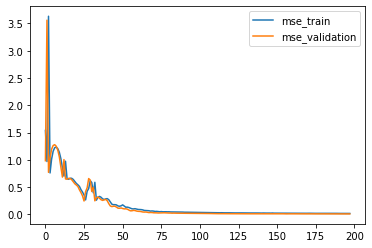

In [10]:
# Train Model ----
# Make sure you're using the GPU runtime type!

# Define Early Stopping and Checkpoint Callbacks
model_filename = '/content/gdrive/My Drive/Research/Uphill_Downhill/code_repo/updownhill_running/data/Model.h5'
data_filename =  '/content/gdrive/My Drive/Research/Uphill_Downhill/code_repo/updownhill_running/data/Data.pkl'
# early stopping
es = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                  mode='min', 
                                  verbose=0, 
                                  patience=30, 
                                  min_delta=0.001, 
                                  restore_best_weights=True
                                  )

# model checkpoint
mc = keras.callbacks.ModelCheckpoint(
    model_filename,
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False
    )

# Fit Model
history_accel = model.fit(
    train_feats, 
    train_y, 
    epochs=1000,
    validation_data=(test_feats, test_y), 
    verbose=1,
    batch_size=32, 
    callbacks=[es, mc]
    )

# Plot Train/Validation Loss across epochs
plt.plot(history_accel.history['loss'], label = 'mse_train')
plt.plot(history_accel.history['val_loss'], label = 'mse_validation')
plt.legend()
plt.show()

1/1 - 1s - loss: 0.0099



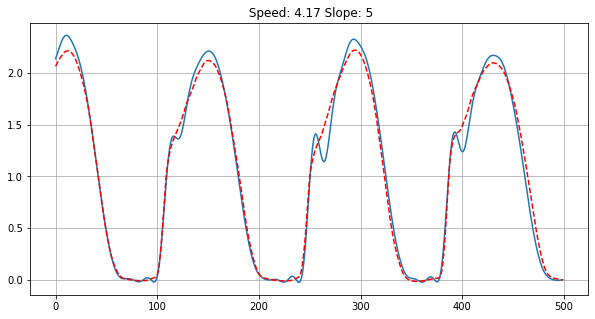

In [11]:
## Load Best Model ----
saved_model = keras.models.load_model(model_filename)

test_scores = saved_model.evaluate(test_feats, test_y, verbose = 2)
pred_final = saved_model.predict(test_feats)
pred_final = np.squeeze(pred_final)

# Plot Prediction vs Measured GRF ----
i = 0 # trial to plot
s = 500  # frame to start plot
e = 1000  # frame to end plot
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(test_y[i,s:e], '-', label='true')
ax.plot(pred_final[i,s:e], 'r--', label='prediction')
ax.grid()
ax.set_title(' Speed: ' + str(test_Sub_Info['Speed'].iloc[i]) + 
             ' Slope: ' + str(test_Sub_Info['Slope'].iloc[i])
             )
print()
plt.show()

In [12]:
## Get Info about Saved Model ----
saved_model.summary()
# saved_model.get_config()

Model: "Accel_subcond_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 13)]        0         
_________________________________________________________________
dropout (Dropout)            (None, None, 13)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 512)         2154496   
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 512)         0         
_________________________________________________________________
dense (Dense)                (None, None, 128)         65664     
_________________________________________________________________
dense_1 (Dense)              (None, None, 384)         49536     
_________________________________________________________________
dense_2 (Dense)              (None, None, 320)  